In [1]:
import pandas as pd

data = pd.read_csv('MEISD/MEISD_text.csv')

In [2]:
df_sentiment = data[['Utterances', 'sentiment']]

In [3]:
target_map = {'positive': 1, 'negative': 0, 'neutral': 2}
df_sentiment['target'] = df_sentiment['sentiment'].map(target_map)
df_sentiment.dropna(subset=['target'], inplace=True)
df_sentiment['target'] = df_sentiment['target'].astype(int)

C:\Users\Julix\AppData\Local\Temp\ipykernel_21484\288194093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment['target'] = df_sentiment['sentiment'].map(target_map)
C:\Users\Julix\AppData\Local\Temp\ipykernel_21484\288194093.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sentiment.dropna(subset=['target'], inplace=True)
C:\Users\Julix\AppData\Local\Temp\ipykernel_21484\288194093.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [4]:
df1 = df_sentiment[['Utterances', 'target']]
df1.columns = ['Utterances', 'label']
df1.to_csv('data.csv', index=False)

In [5]:
df1

,Utterances,label
0,look around you,2
1,say hello to your competition,2
2,eight of you will switch to an easier specialty,2
3,five of you will crack under the pressure,2
4,two of you will be asked to leave,2
...,...,...
20012,"oh, that's right, you're a woman and you need ...",0
20013,i'll try again,0
20014,"please, pam, reconsider and have a bagel",0
20015,i have an early lunch,0


In [6]:
from datasets import load_dataset

raw_dataset = load_dataset('csv', data_files='data.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
def is_valid_example(example):
    return all(value is not None for value in example.values())

raw_dataset = raw_dataset.filter(is_valid_example)

Filter:   0%|          | 0/11351 [00:00<?, ? examples/s]

In [8]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['Utterances', 'label'],
        num_rows: 11351
    })
})

In [9]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [10]:
from transformers import AutoTokenizer
checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

D:\conda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
def tokenize_fn(batch):
    return tokenizer(batch['Utterances'], padding=True, truncation=True)

In [12]:
tokenized_dataset = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/7945 [00:00<?, ? examples/s]

Map:   0%|          | 0/3406 [00:00<?, ? examples/s]

In [13]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
training_args = TrainingArguments(output_dir='training_dir',
                                  eval_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=3,
                                  per_device_train_batch_size=16,
                                  per_device_eval_batch_size=64)

In [15]:
from sklearn.metrics import f1_score
import numpy as np

def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='micro')
    return {'accuracy' : acc, 'f1_score' : f1}

In [16]:
trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset=tokenized_dataset['test'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics
)

In [17]:
print(tokenized_dataset['train'][0])

{'Utterances': "but i have to admit, i'll miss you", 'label': 1, 'input_ids': [101, 1133, 178, 1138, 1106, 5890, 117, 178, 112, 1325, 5529, 1128, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [18]:
tokenized_dataset  

DatasetDict({
    train: Dataset({
        features: ['Utterances', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 7945
    })
    test: Dataset({
        features: ['Utterances', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3406
    })
})

In [19]:
trainer.train() 

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,No log,1.001126,0.522020,0.522020
2,1.041100,0.949428,0.560482,0.560482
3,0.897500,1.063191,0.566353,0.566353


TrainOutput(global_step=1491, training_loss=0.8606988406677042, metrics={'train_runtime': 3255.2162, 'train_samples_per_second': 7.322, 'train_steps_per_second': 0.458, 'total_flos': 773184986556822.0, 'train_loss': 0.8606988406677042, 'epoch': 3.0})

In [39]:
from transformers import pipeline

saved_model = pipeline('text-classification', model='training_dir/checkpoint-1491')

In [40]:
split['test']

Dataset({
    features: ['Utterances', 'label'],
    num_rows: 3406
})

In [41]:
predictions = saved_model(split['test']['Utterances'])

In [42]:
predictions[:10]

[{'label': 'LABEL_1', 'score': 0.8197320103645325},
 {'label': 'LABEL_2', 'score': 0.6306713819503784},
 {'label': 'LABEL_1', 'score': 0.9507781267166138},
 {'label': 'LABEL_1', 'score': 0.9388515949249268},
 {'label': 'LABEL_0', 'score': 0.6836824417114258},
 {'label': 'LABEL_1', 'score': 0.914080798625946},
 {'label': 'LABEL_2', 'score': 0.8721112012863159},
 {'label': 'LABEL_2', 'score': 0.9468514919281006},
 {'label': 'LABEL_1', 'score': 0.4065212309360504},
 {'label': 'LABEL_2', 'score': 0.9392520785331726}]

In [43]:
def get_label(d):
    return int(d['label'].split('_')[1])
predictions = [get_label(d) for d in predictions]

In [44]:
from sklearn.metrics import accuracy_score

print('acc:',accuracy_score(split['test']['label'], predictions))

acc: 0.5663534938344099


In [45]:
print('f1:',f1_score(split['test']['label'], predictions, average='macro'))


f1: 0.5566504762548563


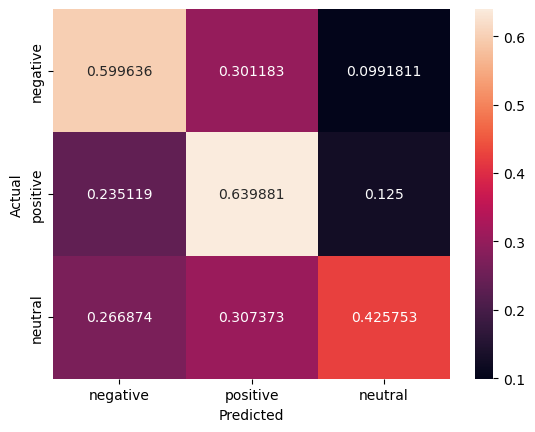

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(cm):
    classes = ['negative', 'positive', 'neutral']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sns.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
cm = confusion_matrix(split['test']['label'],predictions, normalize='true')
plot_cm(cm)